In [1]:
import cv2

img = cv2.imread("/home/issa/Desktop/personal/watches/isolate_hands/data/hands/DSC00027e_720x.jpg")

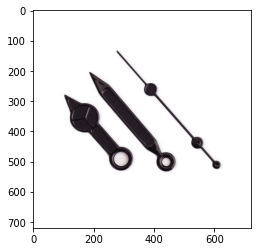

In [2]:
from matplotlib import pyplot as plt

plt.imshow(img)

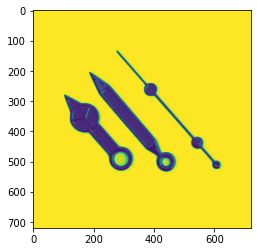

In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(gray)

In [4]:
_, thresholded = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY_INV)

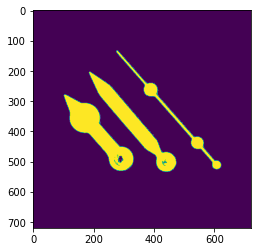

In [5]:
plt.imshow(thresholded)

In [6]:
contours, hierarchy = cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

In [7]:
import numpy as np

masks = []

for i in range(3):
    mask = np.zeros_like(img)
    mask = cv2.drawContours(mask, contours[i:i+1], -1, (0,255,0), thickness=cv2.FILLED)
    masks.append(mask[:, :, 1])

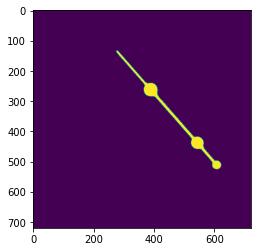

In [8]:
plt.imshow(masks[2])

In [9]:
import math

angles = []
centers = []

for mask in masks:
    moments = cv2.moments(mask)
    center_x = moments["m10"] / moments["m00"]
    center_y = moments["m01"] / moments["m00"]

    a = moments["m20"] / moments["m00"] - center_x ** 2;
    b = 2 * (moments["m11"] / moments["m00"] - center_x * center_y);
    c = moments["m02"] / moments["m00"] - center_y ** 2;

    flag = 1 if a < c else 0
    theta = 1 / 2 * math.atan(b / (a - c)) + flag * math.pi / 2;

    angles.append(theta * 180 / math.pi - 90)
    centers.append((center_x, center_y))

In [10]:
def rotate_image(image, angle, center):
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

In [11]:
rotated_masks = []

for mask, angle, center in zip(masks, angles, centers):
    rotated_masks.append(rotate_image(mask, angle, center))

In [12]:
bboxes = []

for rotated_mask in rotated_masks:
    where = np.where(rotated_mask > 0)
    y1 = where[0].min()
    x1 = where[1].min()
    y2 = where[0].max()
    x2 = where[1].max()
    bboxes.append((x1, y1, x2, y2))

In [13]:
rotated_images = []

for angle, center in zip(angles, centers):
    rotated_images.append(rotate_image(img, angle, center))

In [14]:
cropped_images = []

for rotated_image, bbox in zip(rotated_images, bboxes):
    cropped_images.append(rotated_image[bbox[1]:bbox[3], bbox[0]:bbox[2], :])

In [15]:
cropped_masks = []

for rotated_mask, bbox in zip(rotated_masks, bboxes):
    cropped_masks.append(rotated_mask[bbox[1]:bbox[3], bbox[0]:bbox[2]])

In [16]:
transparent_crops = []

for cropped_image, cropped_mask in zip(cropped_images, cropped_masks):
    where = np.where(cropped_mask == 0)
    transparent_crop = np.full(cropped_image.shape[:2] + (4,), 255, dtype=np.int32)
    transparent_crop[:, :, :3] = cropped_image
    transparent_crop[where[0], where[1], 3] = 0
    transparent_crops.append(transparent_crop)

In [17]:
for i, transparent_crop in enumerate(transparent_crops):
    cv2.imwrite(f"transparent_crop_{i}.png", transparent_crop)

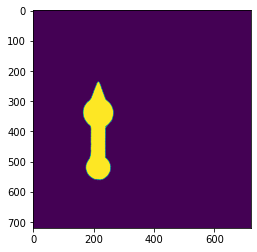

In [18]:
plt.imshow(rotated_masks[0])

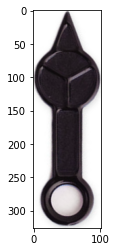

In [21]:
plt.imshow(cropped_images[0])

In [31]:
import numpy as np
import cv2 as cv

img = cropped_images[1].copy()
output = cropped_images[1].copy()
cimg = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
circles = cv.HoughCircles(cimg, cv.HOUGH_GRADIENT, 0.05, 20, param1=20, param2=60, minRadius=2)


circles = np.round(circles[0, :]).astype("int")


for (x, y, r) in circles:
    # draw the circle in the output image, then draw a rectangle
    # corresponding to the center of the circle
    cv2.circle(output, (x, y), r, (0, 255, 0), 4)
    cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)

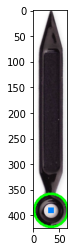

In [32]:
plt.imshow(output)

In [42]:
circles

array([[ 34, 390,  32]])

In [53]:
canvas = np.full([1000, 1000, 4], 0, dtype=np.int32)
canvas[500 - transparent_crops[1].shape[0] + transparent_crops[1].shape[0] - circles[0][1]:500 + transparent_crops[1].shape[0] - circles[0][1], 500 - transparent_crops[1].shape[1] + circles[0][0]:500 + circles[0][0], :] = transparent_crops[1]

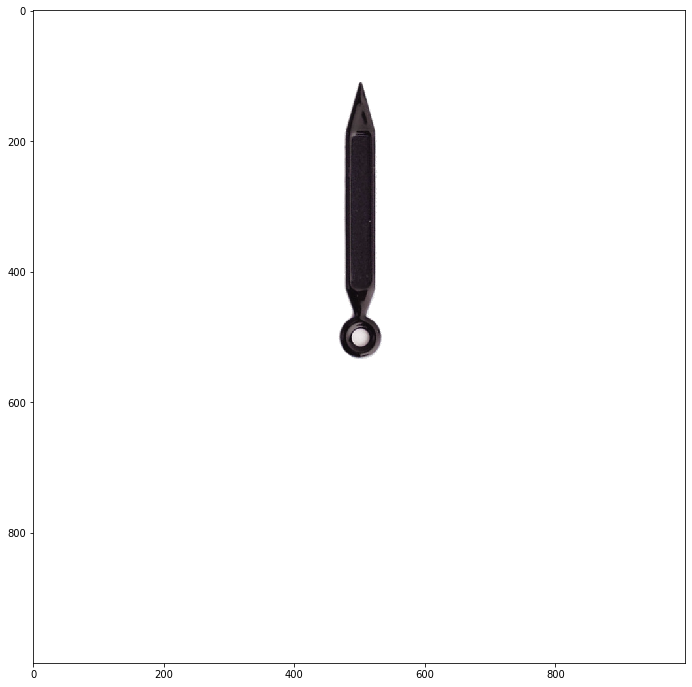

In [54]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(canvas, interpolation='nearest')

In [55]:
cv2.imwrite("thingy.png", canvas)

True

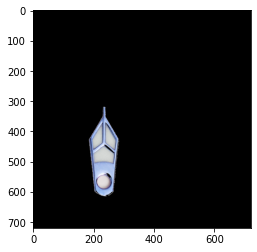

In [15]:
plt.imshow(rotated_masked_images[1])

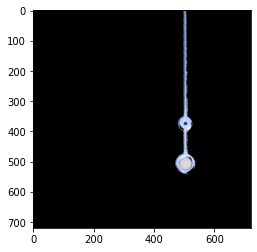

In [16]:
plt.imshow(rotated_masked_images[2])